<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Modeling Walkthrough

_Authors: Riley Dallas (AUS), Adi Bronshtein (Live Online)_

---

### Learning Objectives
*After this lesson, you will be able to:*

- Gather, clean, explore and model a dataset from scratch.
- Split data into testing and training sets using both train/test split and cross-validation and apply both techniques to score a model.


## Importing libaries
---

We'll need the following libraries for today's lesson:

1. `pandas`
2. `numpy`
3. `seaborn`
4. `matplotlib.pyplot`
5. `train_test_split` and `cross_val_score` from `sklearn`'s `model_selection` module
6. `LinearRegression` from `sklearn`'s `linear_model` module
7. `r2_score` from `sklearn`'s `metrics` module 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

## Load the Data

---

Today's [dataset](http://www-bcf.usc.edu/~gareth/ISL/data.html) (`College.csv`) is from the [ISLR website](http://www-bcf.usc.edu/~gareth/ISL/). 

Rename `Unnamed: 0` to `University`.

In [2]:
college = pd.read_csv('./datasets/College.csv')
college.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [3]:
college.rename(columns={'Unnamed: 0':'University'}, inplace=True)
college.head(1)

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60


## Data cleaning: Initial check
---

Check the following in the cells below:
1. Do we have any null values?
2. Are any numerical columns being read in as `object`?

In [4]:
# Check for nulls
college.isnull().sum()

University     0
Private        0
Apps           0
Accept         0
Enroll         0
Top10perc      0
Top25perc      0
F.Undergrad    0
P.Undergrad    0
Outstate       0
Room.Board     0
Books          0
Personal       0
PhD            0
Terminal       0
S.F.Ratio      0
perc.alumni    0
Expend         0
Grad.Rate      0
dtype: int64

In [5]:
college.shape

(777, 19)

In [6]:
# Check column data types
college.dtypes

University      object
Private         object
Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Outstate         int64
Room.Board       int64
Books            int64
Personal         int64
PhD             object
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
dtype: object

![](./assets/modeling-data-cleaning.jpg)

## Data cleaning: Clean up `PhD` column
---

`PhD` is being read in as a string because some of the cells contain non-numerical values. In the cell below, replace any non-numerical values with `NaN`'s, and change the column datatype to float.

In [7]:
# One way - get value_counts()
college['PhD'].value_counts()

?     29
77    26
73    24
90    22
71    21
      ..
34     1
31     1
41     1
22     1
16     1
Name: PhD, Length: 78, dtype: int64

In [8]:
# Second way - get unique values
college['PhD'].unique()

array(['70', '29', '53', '92', '76', '?', '90', '89', '79', '40', '82',
       '73', '60', '36', '78', '48', '62', '69', '83', '55', '88', '57',
       '93', '85', '65', '66', '81', '59', '58', '68', '98', '71', '74',
       '61', '35', '87', '80', '63', '75', '39', '99', '100', '95', '77',
       '72', '64', '10', '86', '22', '50', '41', '8', '67', '94', '56',
       '46', '54', '84', '97', '51', '42', '49', '52', '43', '37', '45',
       '47', '91', '31', '96', '34', '33', '44', '32', '14', '103', '26',
       '16'], dtype=object)

In [9]:
# If it's a very long list, we can sort it!
sorted(list(college['PhD'].unique()), reverse=True)[0:5]

['?', '99', '98', '97', '96']

In [10]:
# Grab all the universities and colleges with missing PhD data
college[college['PhD'].isin(['?'])].head()

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
5,Albertson College,Yes,587,479,158,38,62,678,41,13500,3335,500,675,?,73,9.4,11,9727,55
16,Amherst College,Yes,4302,992,418,83,96,1593,5,19760,5300,660,1598,?,98,8.4,63,21424,100
44,Beloit College,Yes,1320,923,284,26,54,1085,81,16304,3616,355,715,?,95,11.1,26,12957,69
46,Benedictine College,Yes,632,620,222,14,24,702,501,9550,3850,350,250,?,84,14.1,18,5922,58
56,Bloomsburg Univ. of Pennsylvania,No,6773,3028,1025,15,55,5847,946,7844,2948,500,1680,?,68,18.0,19,7041,75


In [11]:
# Use the "replace()" method:
college['PhD'].replace(to_replace='?', value=np.nan)
# # To make it stick - use inplace=True! (uncomment to run)
# college['PhD'].replace(to_replace='?', value=np.nan, inplace=True).astype(float)

0      70
1      29
2      53
3      92
4      76
       ..
772    60
773    73
774    67
775    96
776    75
Name: PhD, Length: 777, dtype: object

In [12]:
# Use a lambda function
college['PhD'].apply(lambda x: np.nan if x == '?' else float(x))
# # if we want to make it "stick" - we need to reassign to the column (uncomment to run)
# college["PhD"] = college['PhD'].apply(lambda x:np.nan if x == '?' else float(x))

0      70.0
1      29.0
2      53.0
3      92.0
4      76.0
       ... 
772    60.0
773    73.0
774    67.0
775    96.0
776    75.0
Name: PhD, Length: 777, dtype: float64

In [13]:
# Third way - using a (defined) function
def clean_phd(row):
    if row == "?":
        return np.nan
    else:
        return float(row)

In [14]:
# Map the column using the function
college['PhD'] = college['PhD'].map(clean_phd)

In [15]:
# Make sure 
college.dtypes

University      object
Private         object
Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Outstate         int64
Room.Board       int64
Books            int64
Personal         int64
PhD            float64
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
dtype: object

## Data cleaning: Drop `NaN`'s
---

Since there are a small percentage of null cells, let's go ahead and drop them.

In [16]:
# Get the number of missing rows
college.isnull().sum()

University      0
Private         0
Apps            0
Accept          0
Enroll          0
Top10perc       0
Top25perc       0
F.Undergrad     0
P.Undergrad     0
Outstate        0
Room.Board      0
Books           0
Personal        0
PhD            29
Terminal        0
S.F.Ratio       0
perc.alumni     0
Expend          0
Grad.Rate       0
dtype: int64

In [17]:
# Get the number of rows before dropping missing values
college.shape

(777, 19)

In [18]:
# Drop the missing values, check the shape
college.dropna(inplace=True)
college.shape

(748, 19)

## Feature engineering: Binarize `'Private'` column
---

In the cells below, convert the `Private` column into numerical values.

In [19]:
college.head()

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70.0,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29.0,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53.0,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92.0,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76.0,72,11.9,2,10922,15


In [20]:
college['Private'].value_counts()

Yes    544
No     204
Name: Private, dtype: int64

In [21]:
# With lambda function:
college['Private'].apply(lambda x: 1 if x == 'Yes' else 0)

0      1
1      1
2      1
3      1
4      1
      ..
772    0
773    1
774    1
775    1
776    1
Name: Private, Length: 748, dtype: int64

In [22]:
# Use the "map()" method (to make it "stick" we'll need reassign to the column)
college['Private'].map({'Yes':1, 'No':0})

0      1
1      1
2      1
3      1
4      1
      ..
772    0
773    1
774    1
775    1
776    1
Name: Private, Length: 748, dtype: int64

In [23]:
# Use the "replace()" method (to make it stick, use inplace=True!)
college['Private'].replace(('Yes', 'No'), (1,0))

0      1
1      1
2      1
3      1
4      1
      ..
772    0
773    1
774    1
775    1
776    1
Name: Private, Length: 748, dtype: int64

In [24]:
# Using np.where() (need to reassign to column)
np.where(college['Private']=='Yes', 1, 0)[0:25]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1])

In [25]:
# Check changes
college['Private'].replace(('Yes', 'No'), (1,0), inplace=True)

In [26]:
college['Private'].value_counts()

1    544
0    204
Name: Private, dtype: int64

## Feature engineering: Create an `Elite` column
---

The `Top10perc` is the percentage of students enrolled that graduated high school in the top 10th percentile. Let's create a column called `Elite` that has the following values:
- 1 if `Top10perc` is greater than or equal to 50%
- 0 if `Top10perc` is less than 50%

In [27]:
college.head()

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70.0,78,18.1,12,7041,60
1,Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29.0,30,12.2,16,10527,56
2,Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53.0,66,12.9,30,8735,54
3,Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92.0,97,7.7,37,19016,59
4,Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76.0,72,11.9,2,10922,15


In [28]:
college['Elite'] = (college['Top10perc'] >= 50).astype(int)
college.head()

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Elite
0,Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70.0,78,18.1,12,7041,60,0
1,Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29.0,30,12.2,16,10527,56,0
2,Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53.0,66,12.9,30,8735,54,0
3,Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92.0,97,7.7,37,19016,59,1
4,Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76.0,72,11.9,2,10922,15,0


## EDA: Plot a Heatmap of the Correlation Matrix
---

Heatmaps are an effective way to visually examine the correlational structure of your predictors. 

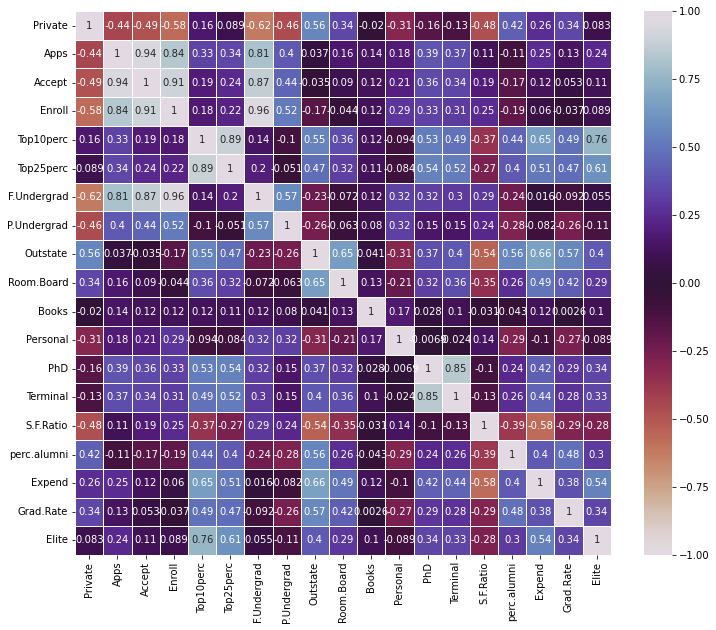

In [29]:
plt.figure(figsize=(12, 10))
sns.heatmap(college.corr(), cmap='twilight_r', annot=True, vmin=-1, vmax=1, linewidths=1);

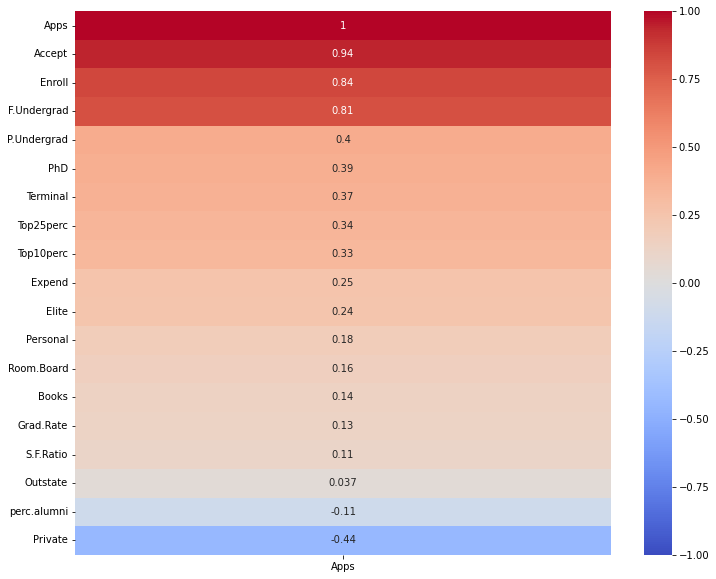

In [30]:
# Heatmap of "Apps" with other features only!
plt.figure(figsize=(12, 10))
sns.heatmap(college.corr()[['Apps']].sort_values(by='Apps', ascending=False),
             annot=True,
             vmin =-1,
             vmax = 1,
              cmap='coolwarm');

## EDA: Use seaborn's `.pairplot()` method to create scatterplots 
---

Let's create a pairplot to see how some of our stronger predictors correlate to our target (`Apps`). Instead of creating a pairplot of the entire DataFrame, we can use the `y_vars` and `x_vars` params to get a smaller subset.

In [31]:
college.columns

Index(['University', 'Private', 'Apps', 'Accept', 'Enroll', 'Top10perc',
       'Top25perc', 'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board',
       'Books', 'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni',
       'Expend', 'Grad.Rate', 'Elite'],
      dtype='object')

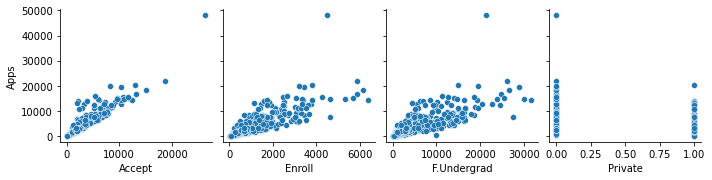

In [32]:
sns.pairplot(data=college, y_vars=['Apps'], x_vars=['Accept', 'Enroll', 'F.Undergrad', 'Private']);

In [33]:
# Code by John
college[college['Accept'] == college['Accept'].max()]

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Elite
483,Rutgers at New Brunswick,0,48094,26330,4520,36,79,21401,3712,7410,4748,690,2009,90.0,95,19.5,19,10474,77,0


In [34]:
# Code by Shuya
college.loc[college.Apps > 30000]

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Elite
483,Rutgers at New Brunswick,0,48094,26330,4520,36,79,21401,3712,7410,4748,690,2009,90.0,95,19.5,19,10474,77,0


## EDA: Create histograms of all numerical columns
---

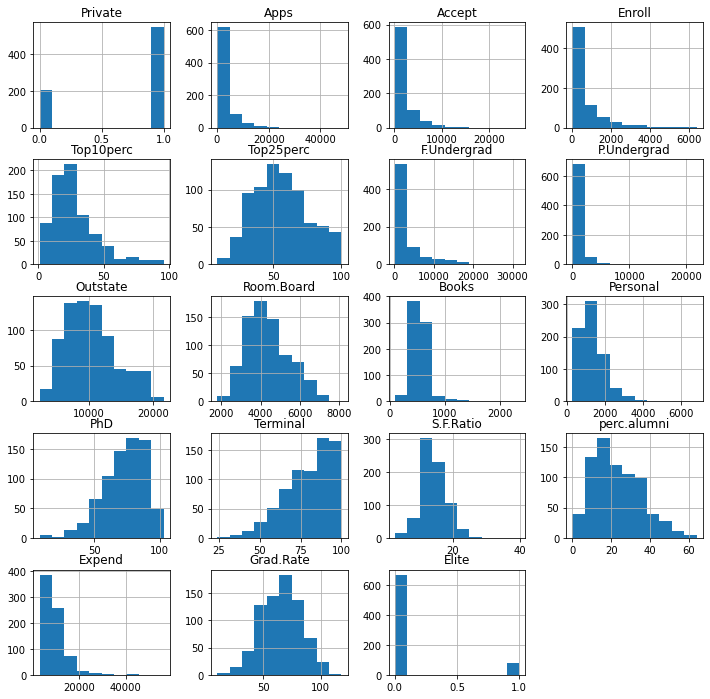

In [35]:
college.hist(figsize=(12,12));

## EDA: Boxplots
---

In the cells below, create two boxplots:
1. One for our target (`Apps`)
2. And one for our strongest predictor (`Accept`)

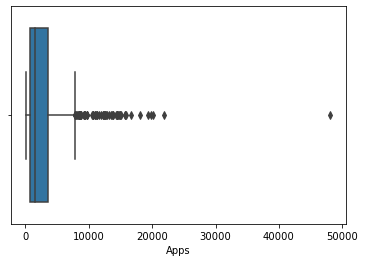

In [36]:
sns.boxplot(x=college['Apps']);

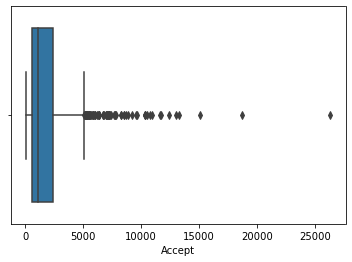

In [37]:
sns.boxplot(x=college['Accept']);

## Model Prep: Create our features matrix (`X`) and target vector (`y`)
---

Every **numerical** column (that is not our target) will be used as a feature.

The `Apps` column is our label: the number of applications received by that university.

In the cell below, create your `X` and `y` variables.

**First way (of grabbing all numerical columns) - same as solution code**:

In [38]:
# This gives me a list of numerical columns
college._get_numeric_data().columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate', 'Elite'],
      dtype='object')

In [39]:
# Using list comprehension - grab all columns EXCPET the "Apps"
features = [col for col in college._get_numeric_data().columns if col != 'Apps']
X = college[features]
y = college['Apps']
X.head()

,Private,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Elite
0,1,1232,721,23,52,2885,537,7440,3300,450,2200,70.0,78,18.1,12,7041,60,0
1,1,1924,512,16,29,2683,1227,12280,6450,750,1500,29.0,30,12.2,16,10527,56,0
2,1,1097,336,22,50,1036,99,11250,3750,400,1165,53.0,66,12.9,30,8735,54,0
3,1,349,137,60,89,510,63,12960,5450,450,875,92.0,97,7.7,37,19016,59,1
4,1,146,55,16,44,249,869,7560,4120,800,1500,76.0,72,11.9,2,10922,15,0


**Second way**:

In [40]:
college.dtypes

University      object
Private          int64
Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Outstate         int64
Room.Board       int64
Books            int64
Personal         int64
PhD            float64
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
Elite            int64
dtype: object

In [41]:
college.drop(columns=['Apps', 'University'])

,Private,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Elite
0,1,1232,721,23,52,2885,537,7440,3300,450,2200,70.0,78,18.1,12,7041,60,0
1,1,1924,512,16,29,2683,1227,12280,6450,750,1500,29.0,30,12.2,16,10527,56,0
2,1,1097,336,22,50,1036,99,11250,3750,400,1165,53.0,66,12.9,30,8735,54,0
3,1,349,137,60,89,510,63,12960,5450,450,875,92.0,97,7.7,37,19016,59,1
4,1,146,55,16,44,249,869,7560,4120,800,1500,76.0,72,11.9,2,10922,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,0,1515,543,4,26,3089,2029,6797,3900,500,1200,60.0,60,21.0,14,4469,40,0
773,1,1805,695,24,47,2849,1107,11520,4960,600,1250,73.0,75,13.3,31,9189,83,0
774,1,1915,695,34,61,2793,166,6900,4200,617,781,67.0,75,14.4,20,8323,49,0
775,1,2453,1317,95,99,5217,83,19840,6510,630,2115,96.0,96,5.8,49,40386,99,1


## Model Prep: Train/test split
---

We always want to have a holdout set to test our model. Use the `train_test_split` function to split our `X` and `y` variables into a training set and a holdout set.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42)

## Model Prep: Instantiate our model
---

Create an instance of `LinearRegression` in the cell below.

In [43]:
linreg = LinearRegression()

## Cross validation
---

Use `cross_val_score` to evaluate our model.

In [44]:
# Training Cross Val
cross_val_score(linreg, X_train, y_train).mean()

0.9107371308411525

In [45]:
# Testing Cross Val
cross_val_score(linreg, X_test, y_test).mean()

0.8950358081872647

## Model Fitting and Evaluation
---

Fit the model to the training data, and evaluate the training and test scores below.

In [46]:
# Fit the model on training data
linreg.fit(X_train, y_train)

LinearRegression()

In [47]:
# Training score
linreg.score(X_train, y_train)

0.9250667141387199

In [48]:
# Testing score
linreg.score(X_test, y_test)

0.9155734935364059

**Let's check the residuals! (errors)**

In [49]:
# Let's create predictions!
train_preds = linreg.predict(X_train)
test_preds = linreg.predict(X_test)

In [50]:
# MSE for training
mean_squared_error(y_true=y_train, y_pred=train_preds)

841729.1365164202

In [51]:
# MSE for testing
mean_squared_error(y_true=y_test, y_pred=test_preds)

1946888.508989465

In [52]:
# RMSE for training
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

917.4579753407892

In [53]:
# RMSE for testing
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

1395.309467103791

In [54]:
# Look at the coefficients
linreg.coef_

array([-4.38715723e+02,  1.28023298e+00, -1.97936844e-01,  4.20952662e+01,
       -1.24231136e+01,  5.66956876e-02,  3.62038577e-02, -6.67668254e-02,
        1.44143958e-01,  3.17488768e-02,  8.77327483e-03, -7.03386136e+00,
       -1.44108771e+00,  2.35469500e+01, -1.35152020e+00,  8.33856916e-02,
        7.60408343e+00, -2.18329737e+01])

In [55]:
# Zip the coefficients and features together 
list(zip(features, linreg.coef_))

[('Private', -438.7157227348995),
 ('Accept', 1.280232980533468),
 ('Enroll', -0.19793684357382557),
 ('Top10perc', 42.09526618293434),
 ('Top25perc', -12.423113551412364),
 ('F.Undergrad', 0.05669568757385973),
 ('P.Undergrad', 0.03620385774729405),
 ('Outstate', -0.06676682543446111),
 ('Room.Board', 0.1441439576940885),
 ('Books', 0.031748876782809646),
 ('Personal', 0.0087732748314439),
 ('PhD', -7.033861359651243),
 ('Terminal', -1.441087710833083),
 ('S.F.Ratio', 23.54694995859276),
 ('perc.alumni', -1.3515201951050064),
 ('Expend', 0.08338569155828655),
 ('Grad.Rate', 7.604083432220216),
 ('Elite', -21.83297367458482)]

In [56]:
# Put it into a dataframe
pd.DataFrame(list(zip(features, linreg.coef_)), columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
3,Top10perc,42.095266
13,S.F.Ratio,23.546950
16,Grad.Rate,7.604083
1,Accept,1.280233
8,Room.Board,0.144144
15,Expend,0.083386
5,F.Undergrad,0.056696
6,P.Undergrad,0.036204
9,Books,0.031749
10,Personal,0.008773
